In [27]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [28]:
model = kan.MultKAN.loadckpt('model_files/best_bash_model_10_3_1_1_1')

In [29]:
model.width

[[10, 0], [3, 0], [1, 0], [1, 0], [1, 0]]

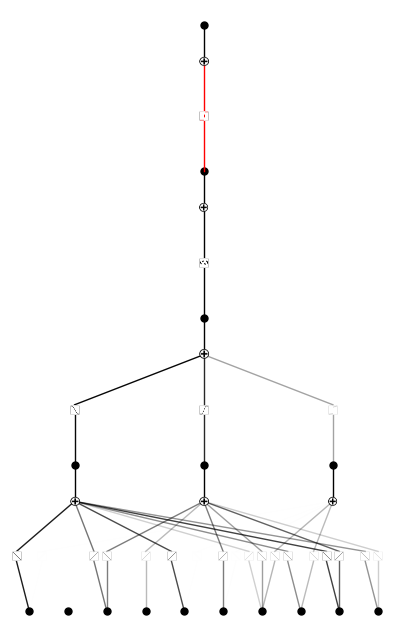

In [30]:
model.plot()

In [31]:
model.symbolic_fun[3].affine

Parameter containing:
tensor([[[ 5.9176e+00,  2.6579e-01,  1.0006e+00, -1.4380e-04]]],
       requires_grad=True)

In [6]:
N=10; J1=1; J2=0.2
h = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs = h.eigenstates()
gs = eigs[1][0]
gse = eigs[0][0]

threshold = 1e-10
statesf = []
signsf = []
for i in range(0, 2 ** N):
    val = gs[i][0].real
    if abs(val) > threshold: 
        statesf.append(i)
        signsf.append(-1 + 2 * int(val > 0))
pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]

print(len(statesf))
deviations = []
for state, true, calc in zip(statesf, signsf, pred_signsf):
    if true != calc:
        deviations.append(state)
        print(f'fail {bin(state)}, val {gs[state][0].real}, pred {calc}')
print(len(deviations))


input = utils.generate_input_samples(N, statesf)
labels = torch.tensor(signsf, dtype=torch.float64).reshape((-1, 1))
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}

252
fail 0b11111, val -5.154362876348855e-05, pred 1
fail 0b111110, val 5.15436287634932e-05, pred -1
fail 0b1111100, val -5.154362876348732e-05, pred 1
fail 0b11111000, val 5.154362876348707e-05, pred -1
fail 0b111110000, val -5.154362876348749e-05, pred 1
fail 0b1000001111, val 5.1543628763487176e-05, pred -1
fail 0b1100000111, val -5.1543628763487244e-05, pred 1
fail 0b1110000011, val 5.1543628763487115e-05, pred -1
fail 0b1111000001, val -5.154362876348747e-05, pred 1
fail 0b1111100000, val 5.15436287634872e-05, pred -1
10


In [7]:
torch.sqrt(torch.mean((model(input) - labels) ** 2))

tensor(0.0015, dtype=torch.float64, grad_fn=<SqrtBackward0>)

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        cos    0.890217 -3.187143           2                2   -1.631000
1        sin    0.890157 -3.186352           2                2   -1.630446
2          0    0.000000  0.000014           0                0    0.000010
3          x    0.007818 -0.011309           1                1    0.292083
4   gaussian    0.448904 -0.859598           3                3    0.298281
5        1/x    0.232103 -0.380997           2                2    0.333302
6        tan    0.320087 -0.556558           3                3    0.510410
7      1/x^2    0.071150 -0.106468           2                2    0.525473
8  1/sqrt(x)    0.048168 -0.071205           2                2    0.550156
9    1/x^0.5    0.048168 -0.071205           2                2    0.550156


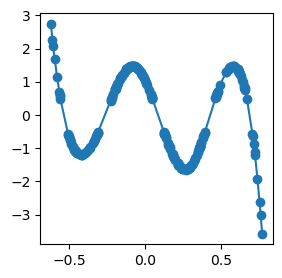

In [9]:
model.get_fun(2, 0, 0);
model.suggest_symbolic(2, 0, 0, topk=10, weight_simple=0.3);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       cos    0.999750 -11.909632           2                2   -7.736742
1       sin    0.999750 -11.908971           2                2   -7.736279
2  gaussian    0.998946  -9.876786           3                3   -6.013750
3      tanh    0.998236  -9.138924           3                3   -5.497247
4    arctan    0.997247  -8.499321           4                4   -4.749525
5         x    0.966628  -4.904797           1                1   -3.133358
6       abs    0.977453  -5.470311           3                3   -2.929218
7       x^2    0.966846  -4.914253           2                2   -2.839977
8       exp    0.966803  -4.912369           2                2   -2.838659
9     x^0.5    0.966743  -4.909751           2                2   -2.836826
   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0       sin    0.997707 -8.762126           2                2   -5.533488
1       cos   

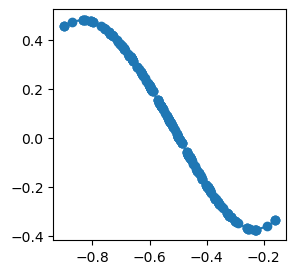

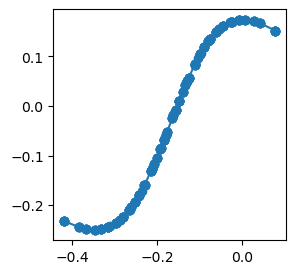

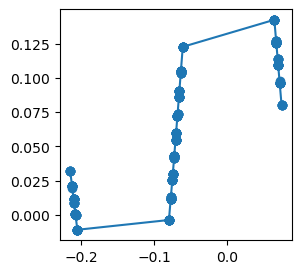

In [10]:
for i in range(model.width[1][0]):
    model.get_fun(1, i, 0);
    model.suggest_symbolic(1, i, 0, topk=10, weight_simple=0.3);

In [11]:
model.fix_symbolic(2, 0, 0, 'cos');
model.fix_symbolic(1, 0, 0, 'cos');
model.fix_symbolic(1, 1, 0, 'cos');

Best value at boundary.
r2 is 0.8902170658111572
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.7
r2 is 0.9997500777244568
saving model version 1.8
r2 is 0.9977066516876221
saving model version 1.9


In [12]:
torch.sqrt(torch.mean((model(input) - labels) ** 2))

tensor(0.3003, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [13]:
model.fit(dataset, steps=20); # THIS IS VERY GOOD LOSS 1.26e-4!!

| train_loss: 1.26e-04 | test_loss: 1.26e-04 | reg: 6.21e+00 | : 100%|█| 20/20 [00:07<00:00,  2.69it

saving model version 1.10


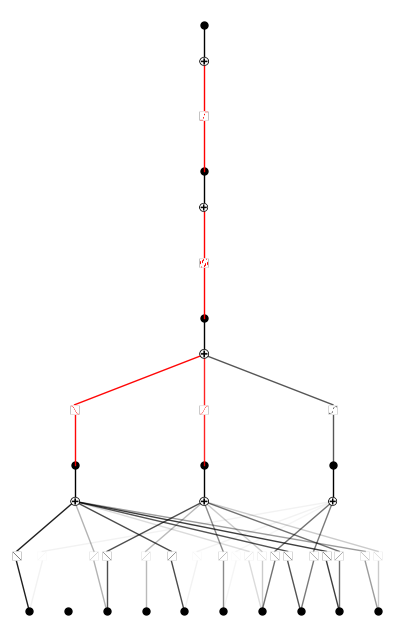

In [14]:
model.plot()

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0  gaussian    0.923548 -3.709122           3                3   -1.696385
1         x    0.845698 -2.696073           1                1   -1.587251
2       sin    0.870533 -2.949227           2                2   -1.464459
3       cos    0.870529 -2.949190           2                2   -1.464433
4     1/x^2    0.863714 -2.875187           2                2   -1.412631
5       exp    0.845918 -2.698138           2                2   -1.288696
6       x^2    0.845714 -2.696227           2                2   -1.287359
7     x^0.5    0.845608 -2.695239           2                2   -1.286667
8      sqrt    0.845608 -2.695239           2                2   -1.286667
9       log    0.845359 -2.692909           2                2   -1.285036


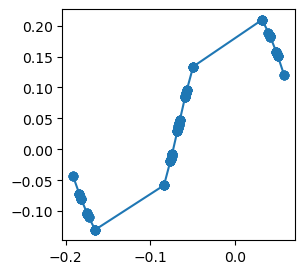

In [15]:
model.get_fun(1, 2, 0);
model.suggest_symbolic(1, 2, 0, topk=10, weight_simple=0.3);

In [17]:
model.fix_symbolic(1, 2, 0, 'cos');

Best value at boundary.
r2 is 0.8705291748046875
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.11


In [18]:
model.fit(dataset, steps=20); # 6.52e-5 loss !!

| train_loss: 6.52e-05 | test_loss: 6.52e-05 | reg: 4.70e+00 | : 100%|█| 20/20 [00:06<00:00,  2.97it

saving model version 1.12


In [20]:
model.auto_symbolic(r2_threshold=0.9);

fixing (0,0,0) with x, r2=1.000001072883606, c=1
fixing (0,0,1) with 0
fixing (0,0,2) with x, r2=1.0000007152557373, c=1
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,2,0) with x, r2=1.0000008344650269, c=1
fixing (0,2,1) with x, r2=1.0000011920928955, c=1
fixing (0,2,2) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with x, r2=1.0000005960464478, c=1
fixing (0,3,2) with 0
fixing (0,4,0) with x, r2=1.0000009536743164, c=1
fixing (0,4,1) with 0
fixing (0,4,2) with x, r2=1.0000007152557373, c=1
fixing (0,5,0) with 0
fixing (0,5,1) with x, r2=1.0000009536743164, c=1
fixing (0,5,2) with x, r2=1.0000008344650269, c=1
fixing (0,6,0) with 1/x^2, r2=1.0000011920928955, c=2
fixing (0,6,1) with x, r2=1.0000007152557373, c=1
fixing (0,6,2) with x, r2=1.000001072883606, c=1
fixing (0,7,0) with x, r2=1.0000008344650269, c=1
fixing (0,7,1) with 0
fixing (0,7,2) with x, r2=1.0000008344650269, c=1
fixing (0,8,0) with x, r2=1.0000011920928955, c=1
fixing (0,8,1) with x, r2=1.

In [21]:
model.fit(dataset, steps=20);

| train_loss: 6.52e-05 | test_loss: 6.52e-05 | reg: 0.00e+00 | : 100%|█| 20/20 [00:01<00:00, 16.75it

saving model version 1.14


In [22]:
ku.ex_round(model.symbolic_formula()[0][0], 4)

1.0*tanh(13.6419*cos(1.5183*cos(-0.4894*x_1 + 0.4766*x_5 + 0.6683*x_6 + 1.5861*x_7 + 0.8459*x_8 + 6.3179) + 3.6342*cos(0.9957*x_1 + 0.4026*x_10 - 0.3726*x_3 - 0.7047*x_5 + 0.5395*x_8 + 0.7506*x_9 - 2.3785) - 2.6377*cos(-0.3715*x_10 - 1.0431*x_3 + 0.3248*x_4 + 0.9893*x_6 - 0.4443*x_7 + 1.0255*x_9 + 7.6147) + 7.8591) - 0.0672)

In [24]:
model.saveckpt('model_files/symbolic_best_bash_model')

In [34]:
model2 = kan.MultKAN.loadckpt('model_files/bash_model_10_2_1_1_1')
model2.width

c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'{path}_state')
c:\Users\taoha\ana

[[10, 0], [2, 0], [1, 0], [1, 0], [1, 0]]

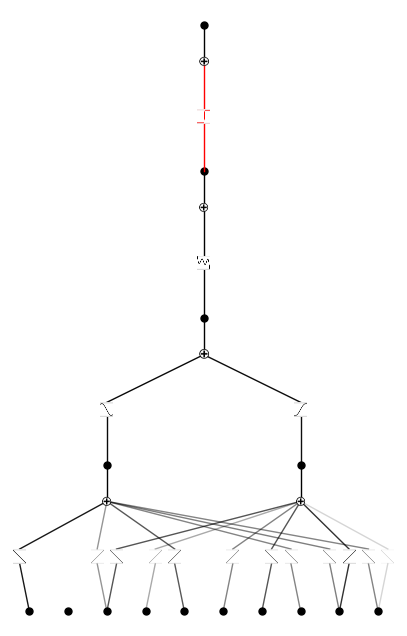

In [35]:
model2.plot()

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        cos    0.817027 -2.450220           2                2   -1.115154
1        sin    0.817012 -2.450099           2                2   -1.115070
2          0    0.000000  0.000014           0                0    0.000010
3          x    0.031178 -0.045682           1                1    0.268023
4   gaussian    0.413645 -0.770129           3                3    0.360910
5      1/x^2    0.134348 -0.208125           2                2    0.454313
6        1/x    0.122895 -0.189162           2                2    0.467587
7    1/x^0.5    0.110563 -0.169020           2                2    0.481686
8  1/sqrt(x)    0.110563 -0.169020           2                2    0.481686
9        log    0.082677 -0.124483           2                2    0.512862


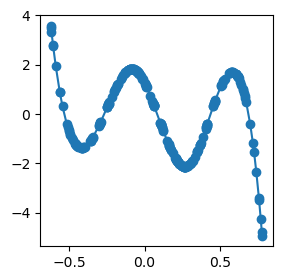

In [36]:
model2.get_fun(2, 0, 0);
model2.suggest_symbolic(2, 0, 0, topk=10, weight_simple=0.3);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       cos    0.999845 -12.562887           2                2   -8.194021
1       sin    0.999845 -12.561846           2                2   -8.193292
2  gaussian    0.997953  -8.925324           3                3   -5.347727
3      tanh    0.997336  -8.546640           3                3   -5.082648
4    arctan    0.995970  -7.951284           4                4   -4.365899
5         x    0.959457  -4.624049           1                1   -2.936834
6       abs    0.973081  -5.214670           3                3   -2.750269
7       x^2    0.959531  -4.626687           2                2   -2.638681
8       exp    0.959517  -4.626188           2                2   -2.638332
9     x^0.5    0.959473  -4.624626           2                2   -2.637238
   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      tanh    0.999270 -10.401160           3                3   -6.380812
1  gaussian 

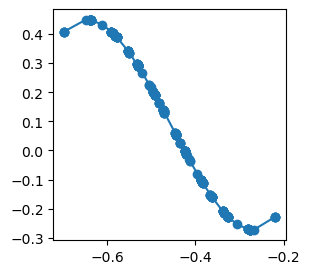

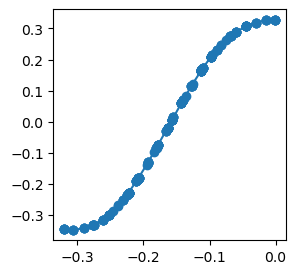

In [37]:
for i in range(model2.width[1][0]):
    model2.get_fun(1, i, 0);
    model2.suggest_symbolic(1, i, 0, topk=10, weight_simple=0.3);

In [38]:
model2.fix_symbolic(2, 0, 0, 'cos');
model2.fix_symbolic(1, 0, 0, 'cos');
model2.fix_symbolic(1, 1, 0, 'tanh');

Best value at boundary.
r2 is 0.8170271515846252
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 1.13
r2 is 0.9998447299003601
saving model version 1.14
Best value at boundary.
r2 is 0.999270498752594
saving model version 1.15


In [39]:
model2.fit(dataset, steps=20);

| train_loss: 8.26e-03 | test_loss: 8.26e-03 | reg: 3.43e+00 | : 100%|█| 20/20 [00:05<00:00,  3.58it

saving model version 1.16


In [40]:
model2.auto_symbolic(r2_threshold=0.95);

fixing (0,0,0) with x, r2=1.0000009536743164, c=1
fixing (0,0,1) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,2,0) with x, r2=1.0000008344650269, c=1
fixing (0,2,1) with x, r2=1.0000008344650269, c=1
fixing (0,3,0) with 0
fixing (0,3,1) with x, r2=1.0000003576278687, c=1
fixing (0,4,0) with x, r2=1.000001072883606, c=1
fixing (0,4,1) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with x, r2=1.0000009536743164, c=1
fixing (0,6,0) with 0
fixing (0,6,1) with x, r2=1.0000007152557373, c=1
fixing (0,7,0) with x, r2=1.0000004768371582, c=1
fixing (0,7,1) with 0
fixing (0,8,0) with x, r2=1.0000005960464478, c=1
fixing (0,8,1) with x, r2=1.0000009536743164, c=1
fixing (0,9,0) with x, r2=1.0000008344650269, c=1
fixing (0,9,1) with x, r2=1.0000007152557373, c=1
skipping (1,0,0) since already symbolic
skipping (1,1,0) since already symbolic
skipping (2,0,0) since already symbolic
skipping (3,0,0) since already symbolic
saving model version 1.17


In [41]:
model2.fit(dataset, steps=20);

| train_loss: 8.22e-03 | test_loss: 8.22e-03 | reg: 0.00e+00 | : 100%|█| 20/20 [00:02<00:00,  9.06it

saving model version 1.18


In [42]:
ku.ex_round(model2.symbolic_formula()[0][0], 4)

0.0001 - 1.0027*tanh(17.4897*cos(3.5855*cos(1.2204*x_1 + 0.7899*x_10 - 0.3171*x_3 - 0.7989*x_5 + 0.4131*x_8 + 0.3134*x_9 - 2.3814) + 4.2788*tanh(-0.5323*x_10 - 0.7551*x_3 + 0.2105*x_4 + 0.3642*x_6 - 0.7582*x_7 + 0.956*x_9 + 0.2572) - 1.5694) + 0.0133)

In [44]:
pred = model2(input)
pred_dev = []
for i in range(labels.shape[0]):
    if torch.sgn(pred[i][0]) != torch.sgn(labels[i][0]):
        pred_dev.append(i)
print(len(pred_dev))

0


In [46]:
sympy.print_latex(ku.ex_round(model2.symbolic_formula()[0][0], 4))

0.0001 - 1.0027 \tanh{\left(17.4897 \cos{\left(3.5855 \cos{\left(1.2204 x_{1} + 0.7899 x_{10} - 0.3171 x_{3} - 0.7989 x_{5} + 0.4131 x_{8} + 0.3134 x_{9} - 2.3814 \right)} + 4.2788 \tanh{\left(- 0.5323 x_{10} - 0.7551 x_{3} + 0.2105 x_{4} + 0.3642 x_{6} - 0.7582 x_{7} + 0.956 x_{9} + 0.2572 \right)} - 1.5694 \right)} + 0.0133 \right)}
